# Inference plots - Trace plots

This example extends from the inference-adaptive-covariance-mcmc: https://github.com/pints-team/pints/blob/master/examples/inference-adaptive-covariance-mcmc.ipynb, and shows you different way to plot the results of an MCMC routine.

Inference plots:
* __Trace plots__
* [Pairwise scatterplots](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-pairwise-scatterplots.ipynb)
* [Autocorrelation plot](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-autocorrelation.ipynb)
* [Predicted time series](https://github.com/pints-team/pints/blob/master/examples/plot-mcmc-predicted-time-series.ipynb)


## Basic MCMC setup

The same setup used in the inference-adaptive-covariance-mcmc example.

In [1]:
from __future__ import print_function
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as pl

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 100)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 50
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleSeriesProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
prior = pints.UniformPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*100]
    )

# Create a Bayesian log-likelihood (prior * likelihood)
log_likelihood = pints.BayesianLogLikelihood(prior, log_likelihood)

# Run an adaptive mcmc routine
x0 = real_parameters * 1.2
mcmc = pints.AdaptiveCovarianceMCMC(log_likelihood, x0)
mcmc.set_verbose(False)


## Trace plots

This allows to make sure that your a priori distribution is well calibrated, and which can be indicated by the parameters having sufficient state changes as the MCMC algorithm runs.

The plots also emphasis the need to discard the burn-in (also known as warm-up) session during the analysis, see: https://github.com/pints-team/pints/blob/master/examples/inference-adaptive-covariance-mcmc.ipynb.

Running
Done!


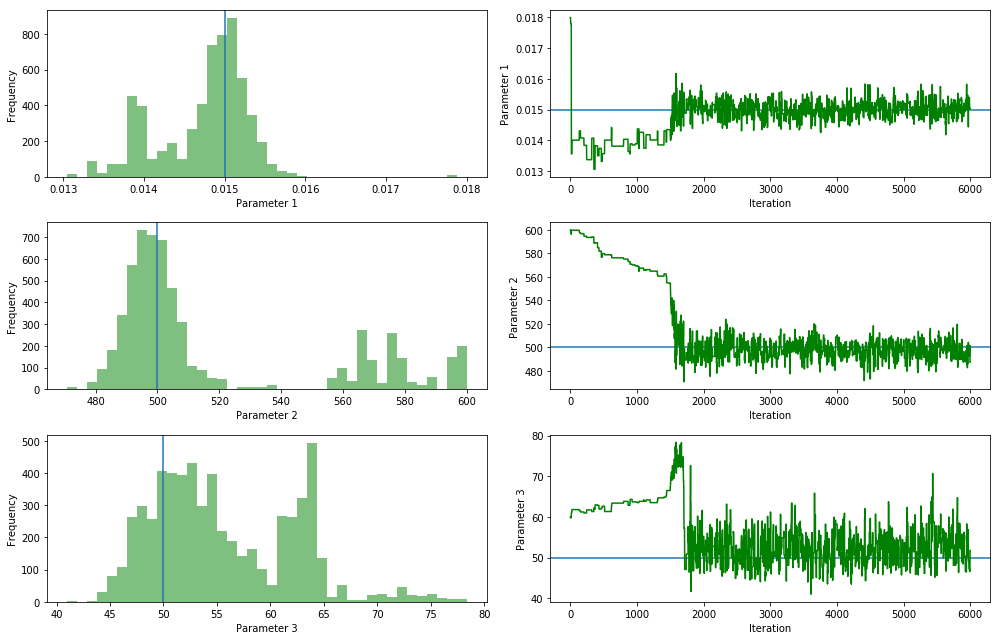

In [2]:
# Disable burn-in and thinning
mcmc.set_burn_in(0)
mcmc.set_thinning_rate(1)

print('Running')
chain = mcmc.run()
print('Done!')

# Show histogram and traces
pl.figure(figsize=(14, 9))
nparam = len(real_parameters)
for i, real in enumerate(real_parameters):
    
    # Add histogram subplot
    pl.subplot(nparam, 2, 1 + 2 * i)
    pl.xlabel('Parameter ' + str(i + 1))
    pl.ylabel('Frequency')
    pl.axvline(real)
    pl.hist(chain[:,i], label='p' + str(i + 1), bins=40, color='green',
        alpha=0.5)

    # Add trace subplot
    pl.subplot(nparam, 2, 2 + 2 * i)
    pl.xlabel('Iteration')
    pl.ylabel('Parameter ' + str(i + 1))
    pl.axhline(real)
    pl.plot(chain[:,i], color='green')

pl.tight_layout()
pl.show()